<a href="https://colab.research.google.com/github/olaidejoseph/g02-sms-spam/blob/master/LSTMSpamnew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from keras.optimizers import SGD, Adam, RMSprop



embedding_dim = 100
max_length = 150
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"



In [2]:
#!wget 'https://raw.githubusercontent.com/HamoyeHQ/g02-sms-spam/master/data/spam_additional.csv'
#!wget 'https://raw.githubusercontent.com/HamoyeHQ/g02-sms-spam/master/data/spam.csv'

In [3]:
data = pd.read_csv('/content/spam.csv', engine='python')
data2 = pd.read_csv('/content/spam_additional.csv')


In [4]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
data2.head()

,Unnamed: 0,Text,spam
0,0,"Dear Customer,\nThis is a confirmation that th...",spam
1,1,"Hello ADEYINKA, present your CV for interview ...",spam
2,2,Edgerit Limited invites you for an interview f...,spam
3,3,You are invited for an aptitude test with UBA ...,spam
4,4,"Mag consult ltd, shortlisted (you/candidate no...",spam


In [6]:
data.dropna(inplace=True,axis=1)
data.rename(columns={"v1":"label","v2":"message"},inplace=True)

In [7]:
data2 = data2[['Text','spam']].copy()
data2.rename(columns={"spam":"label","Text":"message"},inplace=True)

In [8]:
# merge the datframes
data = data.append(data2)

In [9]:
# before shuffling
data.tail(15)

,label,message
425,spam,PayPal Notification Your account has been temp...
426,spam,Never Share this code for your bank OTP 1234 M...
427,spam,Halifax has noticed your Debit card was recent...
428,spam,Free VZW Msg: You're on the phone with Verizon...
429,spam,Santander has noticed your debit card was rece...
430,spam,"Today is our 10 you anniversary! To celebrate,..."
431,spam,WELLS FARGO ALERT: Your CARD starting with 486...
432,spam,"You have been selected for a FREE $1,000 Bestb..."
433,spam,Your BOI online access has been locked for sec...
434,spam,<CitiSG> Did you authorise a charge on your ca...


In [10]:
# To drop duplicated rows
data.drop_duplicates(inplace=True)

In [11]:
# shuffle rows
data = data.sample(frac = 1, random_state=44).reset_index(drop=True)

In [12]:
# after shuffling
data.tail(15)

,label,message
5587,spam,XMAS Prize draws! We are trying to contact U. ...
5588,ham,Ya srsly better than yi tho
5589,ham,Lol its ok I didn't remember til last nite
5590,ham,"Yup. Anything lor, if u dun wan it's ok..."
5591,ham,here is my new address -apples&pairs&all that ...
5592,spam,"Thanks for your ringtone order, reference numb..."
5593,ham,"Hello. No news on job, they are making me wait..."
5594,ham,I had been hoping i would not have to send you...
5595,ham,Wa... U so efficient... Gee... Thanx...
5596,ham,Hey... Thk we juz go accordin to wat we discus...


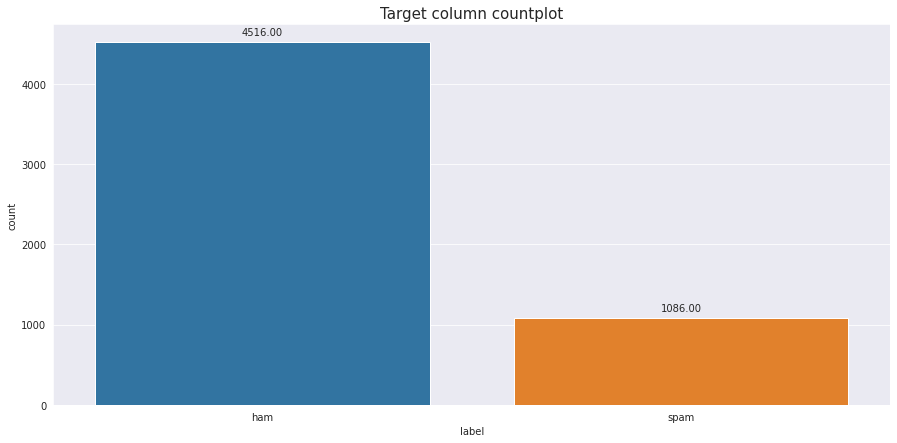

In [13]:
plt.figure(figsize=(15,7))
sns.set_style("darkgrid")
splot = sns.countplot(x="label",data=data)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), \
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.title('Target column countplot', size=15)
plt.show()

The data target is highly imbalance.
Appropriate weight balancing method will be applied to counter the imbalance

# Text Preprocessing

In [14]:
import spacy

In [15]:
nlp = spacy.load('en', disable=['tagger', 'parser', 'ner'])
spacy_stop_words = spacy.lang.en.STOP_WORDS # getting spacy's stop-words

In [16]:
#Stopwords list from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
# Convert it to a Python list and paste it here
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [17]:
stop_words = list(set(list(spacy_stop_words) + stopwords))
stopwords = list({word.lemma_.lower() for word in nlp(' '.join(stop_words))})

In [18]:
# defining tokenzer function to tokenize the lower case lemma of documents in a corpus and 
# filter out stop-words  
def tokenizer_spacy(text):
    return [word.lemma_.lower() for word in nlp(text) if word.is_alpha and word.lemma_.lower() not in stopwords]

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold

In [20]:
sentences = data['message']
labels = data['label']

In [21]:
# Label encoding
encode = LabelEncoder()
labels = encode.fit_transform(labels)

In [22]:
senten = [word for word in sentences if word not in stopwords] # stopword filtering

In [23]:
# tokenize (lemmatize and filter stop words) corpus 
senten = [' '.join(tokenizer_spacy(doc)) for doc in senten]

In [24]:
sentences[0]

"Shuhui has bought ron's present it's a swatch watch..."

In [25]:
senten[0]

'shuhui buy ron present swatch watch'

In [26]:
# word tokenizing
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(senten)

word_index = tokenizer.word_index

In [27]:
vocab_size=len(word_index)

# padding and converting to numeric sequence
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [28]:
print(vocab_size)

7563


In [29]:
training_sequences, test_sequences, training_labels, test_labels = train_test_split(padded, labels, test_size=0.25, random_state=42)

In [30]:
unique_elements, counts_elements = np.unique(training_labels, return_counts=True)
print("Frequency of unique values of the training_labels array:")
print(np.asarray((unique_elements, counts_elements)))

print('\n')

unique_elements, counts_elements = np.unique(test_labels, return_counts=True)
print("Frequency of unique values of the test_labels array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the training_labels array:
[[   0    1]
 [3391  810]]


Frequency of unique values of the test_labels array:
[[   0    1]
 [1125  276]]


# Class weight balancing

In [31]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(labels), class_weight.compute_class_weight('balanced',
                                                 np.unique(labels),
                                                 labels))) 

# Modelling

In [32]:
tf.random.set_seed(1) # for reproducibility

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(305)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 20

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               min_delta=1e-4)

lrp = tf.keraslrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.1,
                                   patience=2,
                                   cooldown=2,
                                   verbose=1)

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    class_weight=class_weights, 
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stopping, lrp],
                    verbose=2)

print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 100)          756400    
_________________________________________________________________
dropout (Dropout)            (None, 150, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 610)               990640    
_________________________________________________________________
dropout_1 (Dropout)          (None, 610)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 611       
Total params: 1,747,651
Trainable params: 1,747,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
132/132 - 14s - loss: 0.3598 - accuracy: 0.8241 - val_loss: 0.0935 - val_accuracy: 0.9707
Epoch 2/20


Evaluation

In [33]:
score = model.evaluate(test_sequences, test_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

44/44 [==============================] - 1s 31ms/step - loss: 0.0519 - accuracy: 0.9879
Test loss: 0.05193272605538368
Test accuracy: 0.9878658056259155


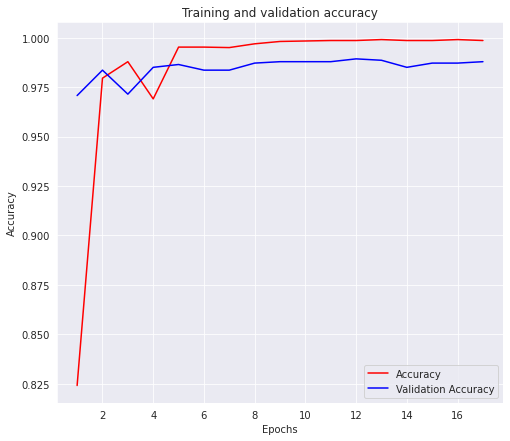

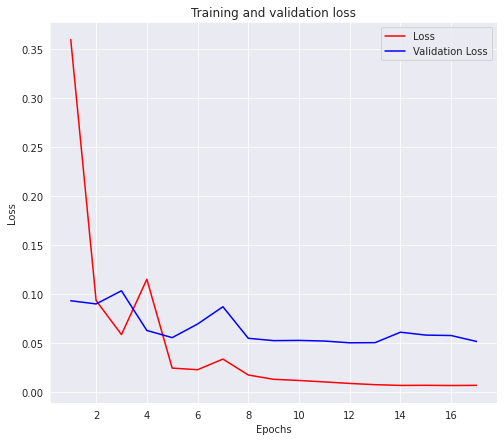

In [34]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(acc)+1) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(8,7))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(8,7))
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])



plt.show()

The best epoch seems to be at 12

In [35]:
tf.random.set_seed(1) # for reproducibility

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(305)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 12

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               min_delta=1e-4)

lrp = tf.keraslrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.1,
                                   patience=2,
                                   cooldown=2,
                                   verbose=1)

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    class_weight=class_weights, 
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stopping, lrp],
                    verbose=2)

print("Training Complete")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          756400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 610)               990640    
_________________________________________________________________
dropout_3 (Dropout)          (None, 610)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 611       
Total params: 1,747,651
Trainable params: 1,747,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
132/132 - 14s - loss: 0.3598 - accuracy: 0.8241 - val_loss: 0.0935 - val_accuracy: 0.9707
Epoch 2/1

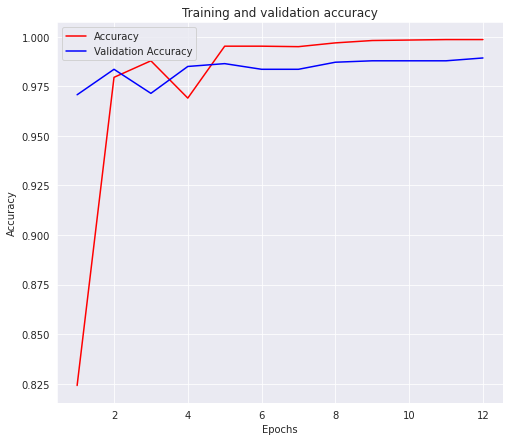

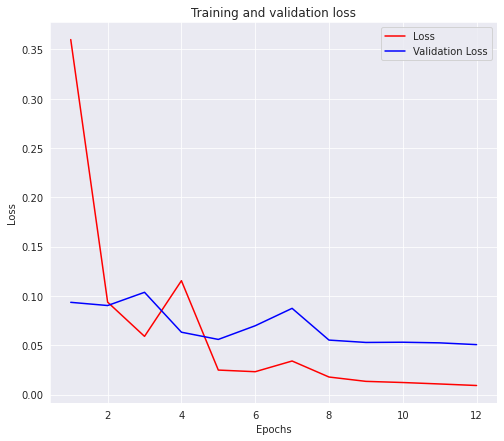

In [36]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(acc)+1) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(8,7))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(8,7))
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()


# Prediction and Evaluation

In [37]:
score = model.evaluate(test_sequences, test_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

44/44 [==============================] - 1s 30ms/step - loss: 0.0506 - accuracy: 0.9893
Test loss: 0.050574395805597305
Test accuracy: 0.9892933368682861


In [38]:
y_pred_train = model.predict(training_sequences)
y_pred_test = model.predict(test_sequences)

In [39]:
y_pred_test[4]

array([0.00165379], dtype=float32)

In [40]:
y_pred_train = [int(np.round(i)) for i in y_pred_train]
y_pred_test = [int(np.round(i)) for i in y_pred_test]

In [41]:
y_pred_test[4]

0

In [42]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, roc_auc_score, confusion_matrix, classification_report

In [43]:
print(classification_report(test_labels, y_pred_test, digits=2))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1125
           1       0.99      0.96      0.97       276

    accuracy                           0.99      1401
   macro avg       0.99      0.98      0.98      1401
weighted avg       0.99      0.99      0.99      1401



In [44]:
print('Training F1 score: {:.4f}'.format(\
    f1_score(training_labels, y_pred_train)))
      
print('Testing F1 score: {:.4f}'.format(\
    f1_score(test_labels, y_pred_test)))

print('\n')

print('Training precision_score: {:.4f}'.format(\
    precision_score(training_labels, y_pred_train)))
      
print('Testing precision_score: {:.4f}'.format(\
    precision_score(test_labels, y_pred_test)))

Training F1 score: 0.9969
Testing F1 score: 0.9725


Training precision_score: 1.0000
Testing precision_score: 0.9851


Note: the f1 score is taking spam as it's positive class

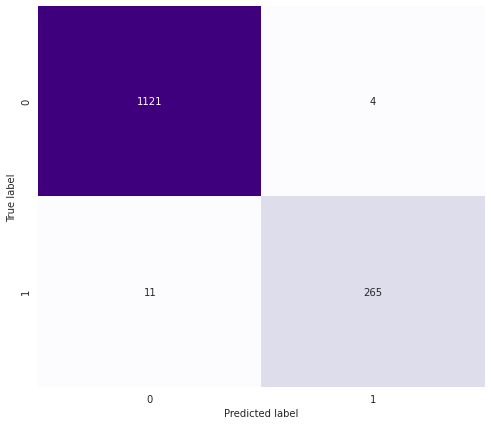

In [45]:
plt.figure(figsize=(8,7))
conf_mat = confusion_matrix(test_labels, y_pred_test)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Purples", cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()